In [7]:
import pickle
import cv2
import numpy as np
import glob
from os import listdir
from os.path import isfile, join
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mping

Text(0.5,1,'Undistorted Image')

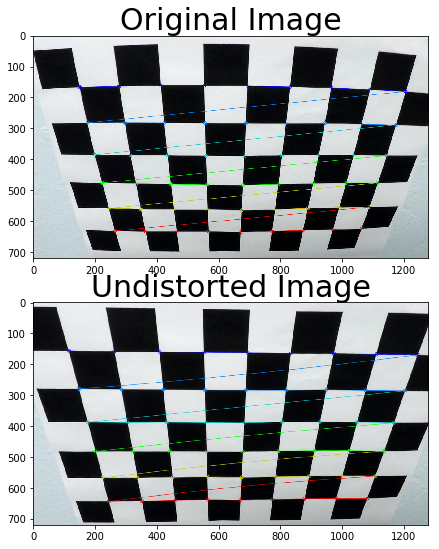

In [8]:
nx=9
ny=6
objpts=[]
imgpts=[]
objp=np.zeros((nx*ny,3), np.float32)
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
img=cv2.imread('camera_cal/calibration2.jpg')
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    objpts.append(objp)
    imgpts.append(corners)
    cv2.drawChessboardCorners(img,(nx, ny),corners,ret)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, gray.shape[::-1], None, None)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
def save(dir, fname, img):
    fname = ''.join([dir,'undistorted_',fname])
    cv2.imwrite(fname,img)
images = ['test1.jpg', 'test2.jpg','test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
for fname in images:
    img = cv2.imread('test_images/'+fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx) 
    save('undistorted_images/', fname, undistorted)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
def absobthresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    scaled_sobel = None
    if orient == 'x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) 
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    else:
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
        abs_sobely = np.absolute(sobely)
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
    thresh_max = thresh[1]
    thresh_min = thresh[0]
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return grad_binary
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    magnitude = np.sqrt(np.square(sobelx)+np.square(sobely))
    abs_magnitude = np.absolute(magnitude)
    scaled_magnitude = np.uint8(255*abs_magnitude/np.max(abs_magnitude))
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= mag_thresh[0]) & (scaled_magnitude <= mag_thresh[1])] = 1
    return mag_binary
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(arctan)
    dir_binary[(arctan >= thresh[0]) & (arctan <= thresh[1])] = 1
    return dir_binary
def combined_s_gradient_thresholds(img, show=False):
    ksize = 3 
    gradx = absobthresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = absobthresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.4))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1
    if show == True:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,10))
        ax1.set_title('Actual image')
        ax1.imshow(img)
        ax3.set_title('Color thresholding')
        ax3.imshow(s_binary, cmap='gray')
        ax2.set_title('Combined grad x,y magnitude and direction')
        ax2.imshow(combined, cmap='gray')
        ax4.set_title('Combined all')
        ax4.imshow(combined_binary, cmap='gray')
    return combined_binary
img = 'undistorted_images/undistorted_test3.jpg'
img = cv2.imread(img)
combined_binary = combined_s_gradient_thresholds(img, True)
img = 'undistorted_images/undistorted_test2.jpg'
img = cv2.imread(img)
combined_binary = combined_s_gradient_thresholds(img, True)


In [ ]:
def transform_image(img, nx, ny): 
    offset = 100 
    img_size = (img.shape[1], img.shape[0])
    leftupperpoint  = [566,470]
    rightupperpoint = [720,470]
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1045,680]
    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    return warped, M
def visualize_transorm_image(combined_binary, warped_img):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(combined_binary, cmap='gray')
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(warped_img,cmap='gray')
    ax2.set_title('Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
warped_img, M = transform_image(combined_binary, nx, ny) 
visualize_transorm_image(combined_binary, warped_img)

In [ ]:
def locate_lines(binary_warped, nwindows = 9, margin = 100, minpix = 50):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)    
    return left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy

def locate_line_further(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new

def visulizeLanes(left_fit, right_fit, left_lane_inds, right_lane_inds, binary_warped, nonzerox, nonzeroy, margin = 100):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
left_fit, right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(warped_img) 
visulizeLanes(left_fit, right_fit, left_lane_inds, right_lane_inds, warped_img, nonzerox, nonzeroy, margin = 100)

In [ ]:
def radius_curvature(binary_warped, left_fit, right_fit):    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700 
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    left_curvature =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]                      
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix 
    position = "left" if center < 0 else "right"
    center = "Vehicle is {:.2f}m {}".format(center, position)
    return left_curvature, right_curvature, center

In [ ]:
left_curvature, right_curvature, center = radius_curvature(warped_img, left_fit, right_fit)

In [ ]:
def draw_on_image(undist, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, show_values = False):
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = np.linalg.inv(M)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], img.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, '{}'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    if show_values == True:
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.imshow(result)        
    return result

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
draw_on_image(img, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, True)

In [ ]:
def is_lane_valid(left_fit, right_fit):
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
    else:
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines >= 150 and delta_lines <=430: 
            status = True
        else:
            status = False
        left = 2*left_fit[0]*360+left_fit[1]
        right = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(left-right)
        if delta_slope_mid <= 0.1:
            status = True
        else:
            status = False
    return status

In [ ]:
class Lane():
    lane = Lane()
def find_lanes(img):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    combined_binary = combined_s_gradient_thresholds(img,False)
    warped_img, M = transform_image(combined_binary, nx, ny) 
    if lane.counter == 0:
        lane.left_fit, lane.right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(warped_img)
    else:
        lane.left_fit, lane.right_fit  = locate_line_further(lane.left_fit, lane.right_fit, warped_img)
    status = is_lane_valid(lane.left_fit, lane.right_fit)
    if status == True:        
        lane.last_left, lane.last_right = lane.left_fit, lane.right_fit        
        lane.counter += 1
        lane.reset_counter = 0
    else: 
        if lane.reset_counter > 4:
            lane.left_fit, lane.right_fit,left_lane_inds, right_lane_inds, nonzerox, nonzeroy = locate_lines(warped_img)
            lane.reset_counter = 0
        else:
            lane.left_fit, lane.right_fit = lane.last_left, lane.last_right
        lane.reset_counter += 1
    return warped_img, lane.left_fit, lane.right_fit, M
def pipeline(img, show_values=False):
    warped_img, left_fit, right_fit, M = find_lanes(img)
    left_curvature, right_curvature, center = radius_curvature(warped_img, left_fit, right_fit)
    return draw_on_image(img, warped_img, left_fit, right_fit, M, left_curvature, right_curvature, center, show_values)
path = ['test1.jpg', 'test2.jpg','test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']
for fname in path:
    img = cv2.imread('test_images/'+fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pipeline(img, True)

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(img):
    return pipeline(img)
white_output = 'Outputvideo/project_video.mp4'
clip = VideoFileClip("project_video.mp4")
white_clip = clip.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))